Make data

In [27]:
from synDataFunctionality.saveSynData import genSynDat
import torch.utils.data as td
from DataLoaders import SynData


In [28]:
from transformers import SegformerForSemanticSegmentation

Test huggingface transformers

In [5]:
import transformers
print(transformers.__version__)

4.26.1


Data

In [29]:
#Test transformations work correctly on dataloader:
from torchvision.transforms import RandomVerticalFlip, RandomHorizontalFlip, Resize, CenterCrop, Normalize
from torchvision.transforms.functional import rotate
import torchvision

#dim = (512,512)

t_both = [RandomHorizontalFlip(p=0.5),  RandomVerticalFlip(p=0.5)]
#Maybe normalize imgs automatically in dataSet

Make data sets

In [31]:
#TrainDataSet = SynData("SynDat/SynInputTrain", "SynDat/SynLabelTrain", transforms_both=t_both, repeat_channels=True)
#TestDataSet = SynData("SynDat/SynInputTrain", "SynDat/SynLabelTrain", transforms_both=t_both, repeat_channels=True)
testDataSet = SynData("SynDat/SynInput", "SynDat/SynLabel", transforms_both=t_both, repeat_channels=True)

In [32]:
#trainLoader = td.DataLoader(TrainDataSet, batch_size=1, shuffle=True)
#validLoader = td.DataLoader(TestDataSet, batch_size=1, shuffle=True)
testLoader = td.DataLoader(testDataSet, batch_size=1)

Load modellen ind. Måske kan vi ændre den, så vi bruger anden loss, og så vi kun bruger én farvekanal

In [23]:
#https://keras.io/examples/vision/segformer/
#https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained
model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,     
    num_labels=2,       #Binær klassifikation
    ignore_mismatched_sizes=True, #do not raise an error if some of the weights from the checkpoint do not have the same size as the weights of the model
    reshape_last_stage=True #https://huggingface.co/transformers/v4.12.5/model_doc/segformer.html
    )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Unfreeze all layers except for the decoder for now

In [207]:
from torch import nn

#Freeze parameters in entire model
for param in model.parameters():
    param.requires_grad = False

#Unfreeze decoder's åarameters
for param in model.decode_head.parameters():
    param.requires_grad = True



Check if CUDA is available

In [15]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Export model to device, and define optimizer

In [211]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.cuda
from transformers import AdamW
from tqdm import tqdm

model.to(device)

#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = AdamW(model.parameters(), lr=0.00006) #model.parameters skal måske ændres??

criterion = nn.BCELoss()
criterion.to(device)

BCELoss()

Train the model. Dobble check that we train the parameters we think we train
https://stackoverflow.com/questions/70256003/how-can-i-only-train-the-classifier-and-freeze-rest-of-the-parameters-in-pytorch

In [212]:
for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values, labels = batch

        #transfer data to device, e.g. GPU
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values.float(), labels=labels[:,0,:, :].long()) #Should not do anything bad

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        #mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted.detach().cpu().numpy()
        true_labels = labels.detach().cpu().numpy()
        #accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        #accuracies.append(accuracy)
        losses.append(loss.item())
        #pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch2 in enumerate(validLoader):
                pixel_values, labels = batch2

                #transfer data to device, e.g. GPU
                pixel_values, labels = pixel_values.to(device), labels.to(device)

                outputs2 = model(pixel_values=pixel_values.float(), labels=labels[:,0,:, :].long())
                upsampled_logits = nn.functional.interpolate(outputs2.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                #mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted.detach().cpu().numpy()
                true_labels = labels.detach().cpu().numpy()
                #accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs2.loss
                #val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Loss: {sum(losses)/len(losses)}\
         Val Loss: {sum(val_losses)/len(val_losses)}") #Tog 10 min før

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1


  1%|          | 2/300 [00:00<00:19, 14.99it/s]

Train Loss: 0.26748802840709685         Val Loss: 0.11999843967457613
Epoch: 2


  1%|          | 2/300 [00:00<00:20, 14.88it/s]

Train Loss: 0.10177609153091907         Val Loss: 0.07730314254760742
Epoch: 3


  1%|          | 2/300 [00:00<00:19, 14.93it/s]

Train Loss: 0.06708053627361854         Val Loss: 0.05835341315716505
Epoch: 4


  1%|          | 2/300 [00:00<00:20, 14.66it/s]

Train Loss: 0.05168131741384665         Val Loss: 0.04878020938485861
Epoch: 5


  1%|          | 2/300 [00:00<00:20, 14.51it/s]

Train Loss: 0.04420004645983378         Val Loss: 0.04258009816830357
Epoch: 6


  1%|          | 2/300 [00:00<00:19, 14.93it/s]

Train Loss: 0.039403168217589456         Val Loss: 0.04024002363284429
Epoch: 7


  1%|          | 2/300 [00:00<00:21, 14.15it/s]

Train Loss: 0.03642219582572579         Val Loss: 0.04020264534900586
Epoch: 8


  1%|          | 2/300 [00:00<00:20, 14.72it/s]

Train Loss: 0.034637860879302027         Val Loss: 0.04377764298891028
Epoch: 9


  1%|          | 2/300 [00:00<00:19, 14.99it/s]

Train Loss: 0.03285158849631747         Val Loss: 0.034220412702610094
Epoch: 10


100%|██████████| 300/300 [00:21<00:00, 13.84it/s]


Train Loss: 0.03190102151284615         Val Loss: 0.032472284976392984


Visualize val and Train loss

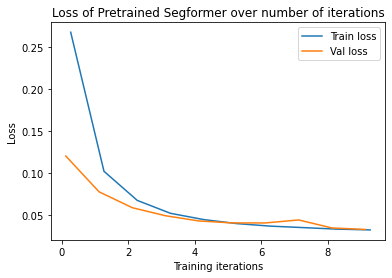

In [219]:
from trainingFunctionality import visualizeLoss #need to fix
trainLoss = [0.26748802840709685, 0.10177609153091907,0.06708053627361854,0.05168131741384665,0.04420004645983378,0.039403168217589456,0.03642219582572579,0.034637860879302027,0.03285158849631747,0.03190102151284615]
valLoss = [0.11999843967457613, 0.07730314254760742, 0.05835341315716505, 0.04878020938485861, 0.04258009816830357, 0.04024002363284429, 0.04020264534900586, 0.04377764298891028, 0.034220412702610094, 0.032472284976392984]
#Here iterations are epochs
visualizeLoss("Pretrained Segformer", 1, trainLoss, valLoss)

Visualize results on test set

In [20]:
import matplotlib.pyplot as plt

for idx, batch2 in enumerate(testLoader):
    img, lab = batch2
    outputs = model(pixel_values=img.to(device).float())
    upsampled_logits = nn.functional.interpolate(outputs.logits, size=lab.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)

    plt.imshow(lab[0][0].numpy(), cmap="gray")
    plt.title("Actual test label {0}".format(idx+1))
    plt.show()
    plt.imshow(predicted[0].cpu().numpy(), cmap="gray")
    plt.title("Predicted test label {0}".format(idx+1))
    plt.show()


NameError: name 'model' is not defined

Save trained model

In [33]:
#save model
modelPath = "savedModels/"
UnetName = "FirstSegFormer"
#saveModel = False

#save model
torch.save(model.state_dict(), (modelPath + UnetName))

Test that we can load in trained model's weights

In [111]:
#Create SegFormer
import torch

model_name1 = "nvidia/segformer-b0-finetuned-ade-512-512"
model1 = SegformerForSemanticSegmentation.from_pretrained(
    model_name1,
    num_labels=2,       #Binær klassifikation
    ignore_mismatched_sizes=True, #do not raise an error if some of the weights from the checkpoint do not have the same size as the weights of the model
    reshape_last_stage=True #https://huggingface.co/transformers/v4.12.5/model_doc/segformer.html
    )

#load trained model's parameters into unet
model1.load_state_dict(torch.load((modelPath + UnetName), map_location=torch.device('cpu')))

model1.to(device)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Success! (As we get same results as earlier)

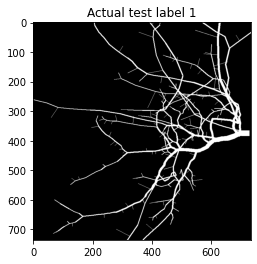

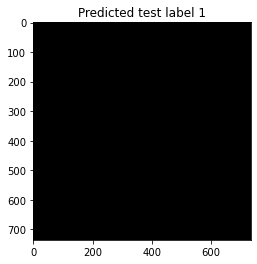

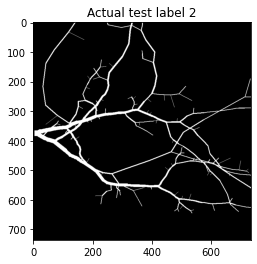

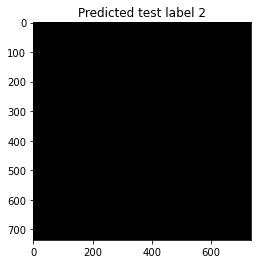

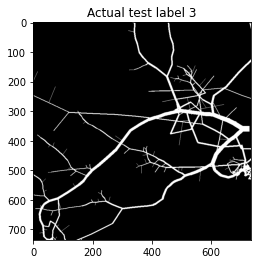

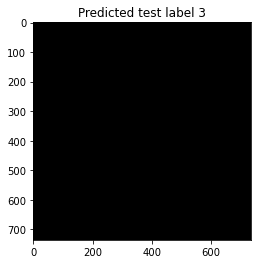

In [112]:
from torch import nn

attention_lst = []

for idx, batch2 in enumerate(testLoader):
    img, lab = batch2
    outputs = model1(pixel_values=img.to(device).float(), output_attentions = True) #output attention maps
    upsampled_logits = nn.functional.interpolate(outputs.logits, size=lab.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)
    attention_lst.append(outputs.attentions)

    plt.imshow(lab[0][0].numpy(), cmap="gray")
    plt.title("Actual test label {0}".format(idx+1))
    plt.show()
    plt.imshow(predicted[0].cpu().numpy(), cmap="gray")
    plt.title("Predicted test label {0}".format(idx+1))
    plt.show()

In [155]:
#attentions for each layer
attentions_dat1 = attention_lst[0]
attentions_dat2 = attention_lst[1]
attentions_dat3 = attention_lst[2]
[print(a.shape) for a in attentions_dat3[0:3]]


torch.Size([1, 1, 33856, 529])
torch.Size([1, 1, 33856, 529])
torch.Size([1, 1, 33856, 529])


[None, None, None]

In [182]:
import numpy as np
processed = []
for feature_map in attentions_dat1:#[0:3]:
    feature_map = feature_map.squeeze(0)
    #print(feature_map.shape)
    gray_scale = feature_map[0]#torch.sum(feature_map,2)
    #print(gray_scale.shape)
    gray_scale = gray_scale / feature_map.shape[0]
    #print(gray_scale.shape[0])
    processed.append(np.reshape(gray_scale.data.cpu().numpy(), (int(np.sqrt(gray_scale.shape[0])) ,int(np.sqrt(gray_scale.shape[0])), -1)))
for fm in processed:
    print(fm.shape)

(184, 184, 529)
(184, 184, 529)
(184, 184, 529)
(92, 92, 529)
(92, 92, 529)
(92, 92, 529)
(92, 92, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(46, 46, 529)
(23, 23, 529)
(23, 23, 529)
(23, 23, 529)


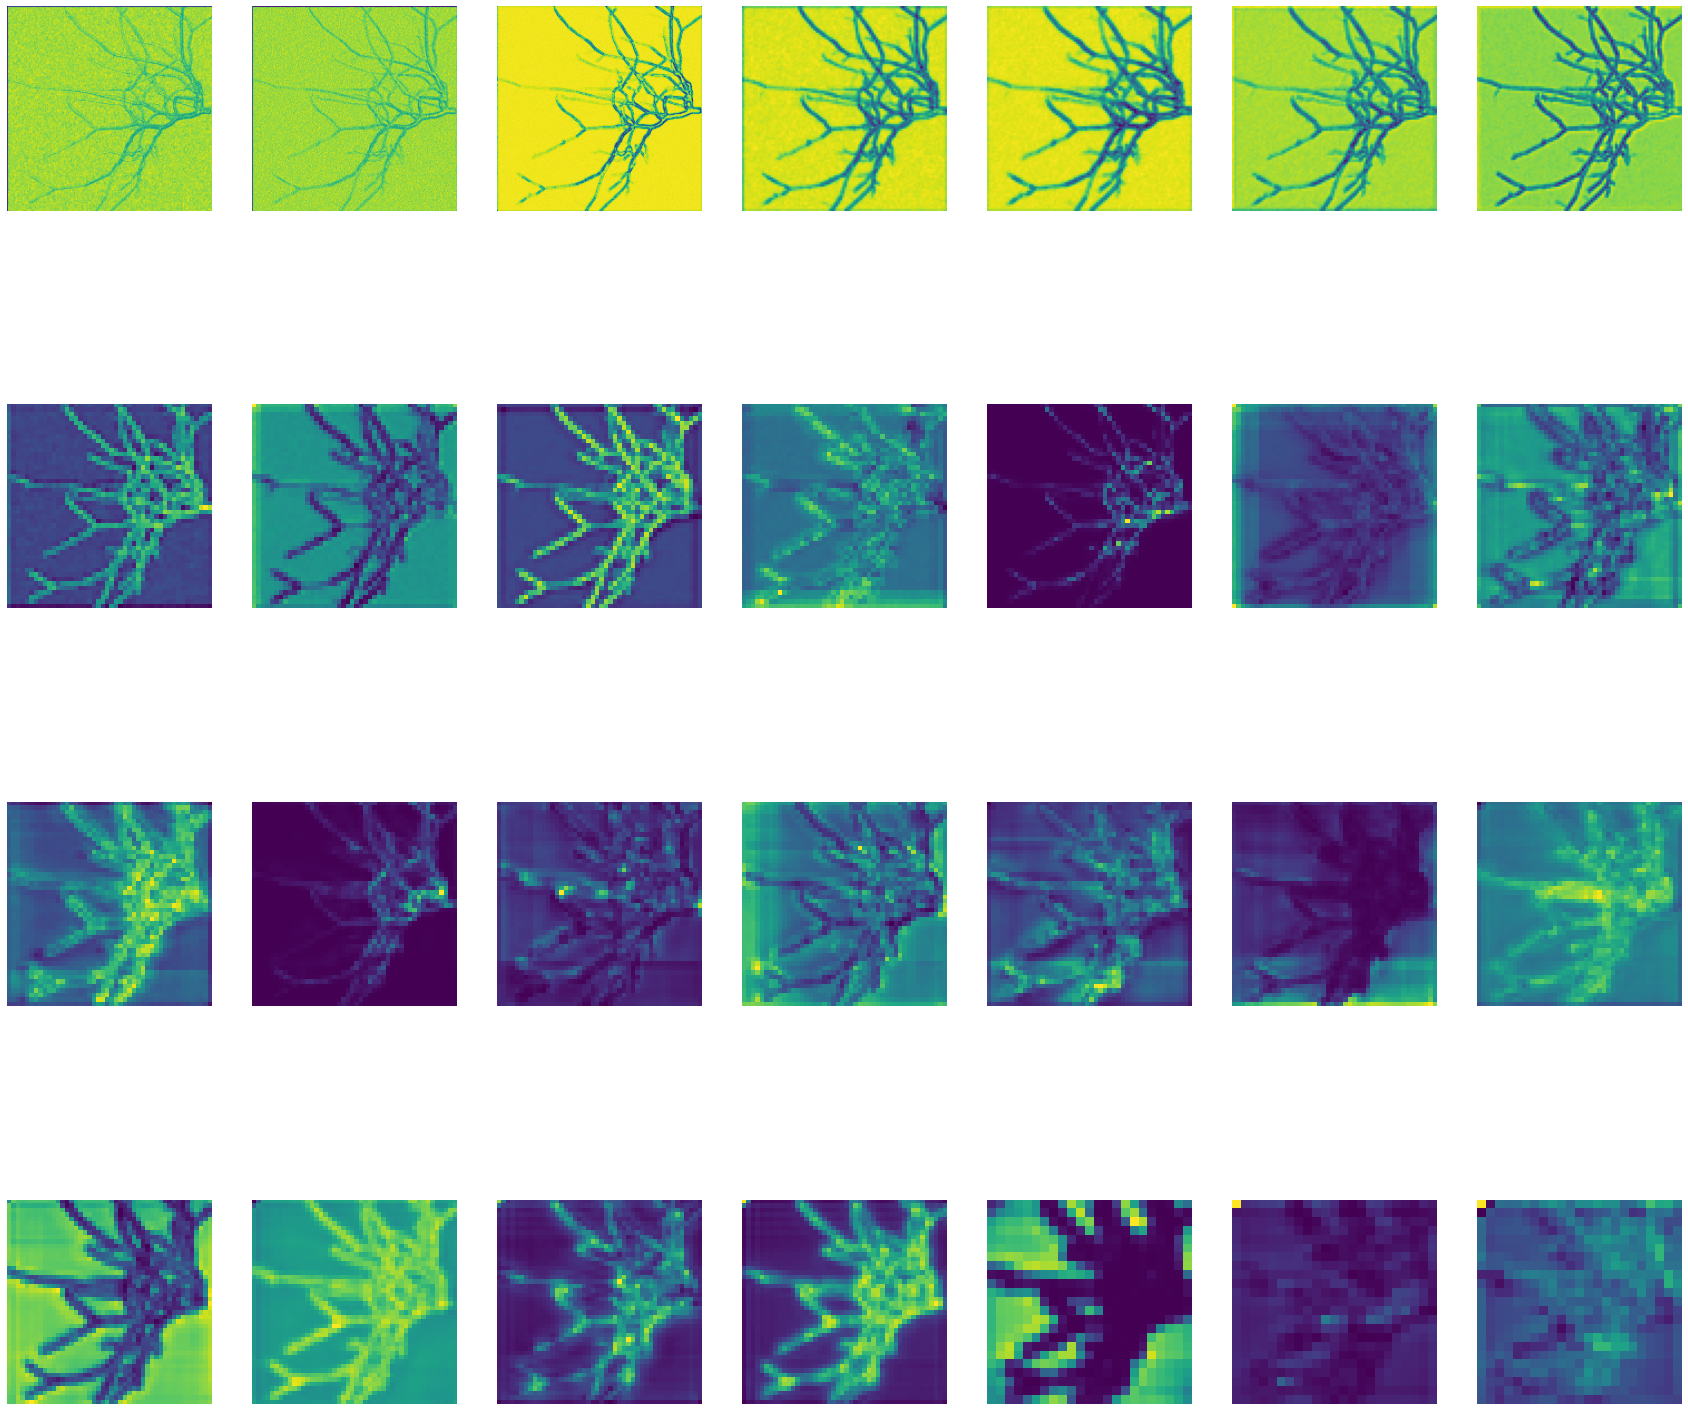

In [197]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(7, 7, i+1) # fig.add_subplot(number of rows, number of cols, i+1)
    imgplot = plt.imshow(processed[i][:, :, i+300])
    a.axis("off")


In [ ]:
#import mmseg
#import mmcv
#print(mmseg.__version__)
#print(mmcv.__version__) #skal opdateres til 2.0

In [ ]:
#from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
#from mmseg.core.evaluation import get_palette


In [ ]:
#config_file = 'mmsegmentation/configs/segmenter/segmenter_vit-l_mask_8x1_640x640_160k_ade20k.py'
#checkpoint_file = 'checkpoints\segmenter_vit-l_mask_8x1_640x640_160k_ade20k_20220614_024513-4783a347.pth'
#
#config_file_segformer = 'mmsegmentation/configs/segformer/segformer_mit-b5_640x640_160k_ade20k.py'
#checkpoint_file_former = 'checkpoints\segformer_mit-b5_640x640_160k_ade20k_20220617_203542-940a6bd8.pth'

In [ ]:
#import skimage.io
#model = init_segmentor(config_file, checkpoint_file, device='cpu')
#model_segformer = init_segmentor(config_file_segformer, checkpoint_file_former, device='cpu')


In [ ]:
#import torch.nn
#
#for param in model_segformer.parameters():
#    param.requires_grad = False
#
#model_segformer.decode_head.conv_seg = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
##model_segformer.mask_norm = torch.nn.LayerNorm((2,), eps=1e-05, elementwise_affine=True)
##model.decode_head.mask_norm = torch.nn.LayerNorm((2,), eps=1e-05, elementwise_affine=True)
#print(model_segformer)

#T ODO
#Edit channels in SegmenterMaskTransformerHead
#Edit channels in last TransformerEncoderLayer

In [ ]:
#import cv2
#img1, lab = TrainDataSet[0]
#img1 = np.array(img1)
#img = np.rollaxis(img1,0,3)
#
#result = inference_segmentor(model_segformer, img)

In [ ]:
#print(result[0].shape)

In [ ]:
#from torchvision.transforms import ToTensor
#print(img.shape)
#plt.imshow(img[:, :, 0])
#plt.show()
#
#plt.imshow(result[0])
#print(np.unique(result[0]))